In [1]:
import subprocess as sp
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns  # for aesthetic

import neuraltda.topology2 as tp2
import neuraltda.spectralAnalysis as sa
import neuraltda.simpComp as sc
import numpy as np
import tempfile
import h5py as h5
import glob
import os
%matplotlib inline

sns.set_style('ticks')

/home/brad/.conda/envs/neuraltda-3/lib/python3.6/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [61]:
def rejection_sampling(command, seed=0):
    # Call sampler with subprocess
    proc = sp.run(command, stdout=sp.PIPE)
    # Read output as a facet list 
    facet_list = []
    for line in proc.stdout.decode().split("\n")[1:-1]:
        if line.find("#") == 0:
            yield facet_list
            facet_list = []
        else:
            facet_list.append([int(x) for x in line.strip().split()])
    yield facet_list
    
def prepare_scm_initial_condition(binmat, **kwargs):
    
    facets = sc.binarytomaxsimplex(binmat, rDup=True, **kwargs)
    with tempfile.NamedTemporaryFile(mode='w+t', delete=False) as f: 
        fname = f.name
        for facet in facets:
            fstr = str(facet)
            fstr = fstr.replace('(', '')
            fstr = fstr.replace(')', '')
            fstr = fstr.replace(',', '')
            f.write(fstr+'\n')
    return fname

def prepare_scm_command(facet_file, nsamps):
    
    command = ['/home/brad/bin/mcmc_sampler', facet_file, '-t', str(nsamps)]
    return command

def extract_population_tensor(binned_data_file, stim, shuffle=False, clusters=None):
    print('Extracting Population Activity Tensor...')
    with h5.File(binned_data_file, 'r') as bdf:
        binned_clusters = np.array(bdf[stim]['clusters'])
        poptens = np.array(bdf[stim]['pop_tens'])
        print('Stim: {}, Clusters:{}'.format(stim, str(clusters)))
        try:
            if clusters is not None:
                poptens = poptens[np.in1d(binned_clusters, clusters), :, :]
                print("Selecting Clusters: poptens:" + str(np.shape(poptens)))
            (ncell, nwin, ntrial) = np.shape(poptens)
        except (ValueError, IndexError):
            print('Population Tensor Error')
            return []
        if shuffle:
            poptens = tp2.build_shuffled_data_tensor(poptens, 1)
            poptens = poptens[:, :, :, 0]
        if  nwin == 0:
            return []
    return poptens
            
def compute_trial_final_bettis(poptens, thresh, trial):
    popmat = poptens[:, :, trial]
    nclus = num_cells(poptens)
    popmat_binary = sc.binnedtobinary(popmat, thresh)
    bettis = tp2.calc_bettis(popmat, np.arange(nclus), '/home/brad/betti_pfile.txt', thresh)
    final_bettis = bettis[-1][1]
    return final_bettis

def compute_betti_curves(poptens, thresh, trial):
    popmat = poptens[:, :, trial]
    nclus = num_cells(poptens)
    bettis = tp2.calc_bettis(popmat, np.arange(nclus), '/home/brad/betti_pfile.txt', thresh)
    max_betti = max([len(x[1]) for x in bettis])
    betticurves = np.zeros((len(bettis), max_betti+1))
    betticurves[:, 0] = [x[0] for x in bettis]
    for bett in range(max_betti):
        betticurves[:, bett+1] = [x[1][bett] for x in bettis]
    return betticurves

def num_trials(poptens):
    (ncells, nwin, ntrials) = np.shape(poptens)
    return ntrials

def num_win(poptens):
    (ncells, nwin, ntrials) = np.shape(poptens)
    return nwin

def num_cells(poptens):
    (ncells, nwin, ntrials) = np.shape(poptens)
    return ncells
      
def calc_scm_betti_distribution(poptens, thresh, trial, nsamples):
    popmat = poptens[:, :, trial]
    popmat_bin = sc.binnedtobinary(popmat, thresh)
    fname = prepare_scm_initial_condition(popmat_bin)
    cmd = prepare_scm_command(fname, nsamples)
    samples = rejection_sampling(cmd)
    sample_bettis = []
    for sample in tqdm.tqdm(samples):
        bettis=[]
        cgs = [[1, x] for x in sample]
        tp2.build_perseus_input(cgs, '/home/brad/betti_pfile.txt')
        betti_file = tp2.run_perseus('/home/brad/betti_pfile.txt')
        try:
            with open(betti_file, 'r') as bf:
                for bf_line in bf:
                    if len(bf_line) < 2:
                        continue
                    betti_data = bf_line.split()
                    filtration_time = int(betti_data[0])
                    betti_numbers = list(map(int, betti_data[1:]))
                    bettis.append(np.array(betti_numbers))
        except:
            bettis.append([-1, [-1]])
        sample_bettis.append(bettis)
    return np.array(sample_bettis)

In [6]:
from importlib import reload
reload(tp2.events)
reload(tp2.core)
reload(tp2)

<module 'neuraltda.topology2' from '/home/brad/code/NeuralTDA/neuraltda/topology2.py'>

In [7]:
winsize = 10.0
segment_info = [0, 0]
pover = 0.5
block_path = '/home/brad/krista/B1083/P03S03/'
# Bin and compute SCG
bfdict = tp2.dag_bin(block_path, winsize, segment_info, cluster_group=['Good', 'MUA'], dt_overlap=pover*winsize, comment='fulltrial')
binned_data_file = glob.glob(os.path.join(bfdict['raw'], '*.binned'))[0]


--- Logging error ---
Traceback (most recent call last):
  File "/home/brad/.conda/envs/neuraltda-3/lib/python3.6/logging/__init__.py", line 994, in emit
    stream.write(msg)
AttributeError: 'int' object has no attribute 'write'
Call stack:
  File "/home/brad/.conda/envs/neuraltda-3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/brad/.conda/envs/neuraltda-3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/brad/.conda/envs/neuraltda-3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/brad/.conda/envs/neuraltda-3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/brad/.conda/envs/neuraltda-3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/home/brad/.conda/envs/neuraltda-3/lib/python3.6/site-pac

Data Not already binned


In [44]:
import tqdm
thresh = 13.0
nsamples = 30
stim_dict = {}
stim_shuffled_dict = {}
stim_scm_dict = {}
stim_betticurve_dict = {}
stim_shuffled_betticurve_dict = {}
with h5.File(binned_data_file, 'r') as bdf:
    stims = bdf.keys()
    for stim in stims:
        print(stim)
        stim_poptens = extract_population_tensor(binned_data_file, stim)
        stim_poptens_shuffled = extract_population_tensor(binned_data_file, stim, shuffle=True)
        ntrials = num_trials(stim_poptens)
        stim_dat = []
        stim_shuffled_dat= []
        stim_scm_dat= []
        stim_betticurve_dat= []
        stim_shuffled_betticurve_dat= []
        for trial in tqdm.tqdm(range(ntrials)):
            
            #stim_bettis = compute_trial_final_bettis(stim_poptens, thresh, trial)
            
            #stim_shuffled_bettis = compute_trial_final_bettis(stim_poptens_shuffled, thresh, trial)
            
            scm_bettis = calc_scm_betti_distribution(stim_poptens, thresh, trial, nsamples)
        
            stim_betticurves = compute_betti_curves(stim_poptens, thresh, trial)
            stim_shuffled_betticurves = compute_betti_curves(stim_poptens_shuffled, thresh, trial)
        
            #stim_dat.append(stim_bettis)
            #stim_shuffled_dat.append(stim_shuffled_bettis)
            stim_scm_dat.append(scm_bettis)
            stim_betticurve_dat.append(stim_betticurves)
            stim_shuffled_betticurve_dat.append(stim_shuffled_betticurves)
        stim_dict[stim] = stim_dat
        stim_shuffled_dict[stim] = stim_shuffled_dat
        stim_scm_dict[stim] = stim_scm_dat
        stim_betticurve_dict[stim] = stim_betticurve_dat
        stim_shuffled_betticurve_dict[stim] = stim_shuffled_betticurve_dat


  0%|          | 0/20 [00:00<?, ?it/s]

I_40k
Extracting Population Activity Tensor...
Stim: I_40k, Clusters:None
Extracting Population Activity Tensor...
Stim: I_40k, Clusters:None



  0%|          | 0/20 [00:00<?, ?it/s]

J_40k
Extracting Population Activity Tensor...
Stim: J_40k, Clusters:None
Extracting Population Activity Tensor...
Stim: J_40k, Clusters:None


  0%|          | 0/20 [00:00<?, ?it/s]

K_40k
Extracting Population Activity Tensor...
Stim: K_40k, Clusters:None
Extracting Population Activity Tensor...
Stim: K_40k, Clusters:None


  0%|          | 0/20 [00:00<?, ?it/s]

L_40k
Extracting Population Activity Tensor...
Stim: L_40k, Clusters:None
Extracting Population Activity Tensor...
Stim: L_40k, Clusters:None


  0%|          | 0/20 [00:00<?, ?it/s]

M_40k
Extracting Population Activity Tensor...
Stim: M_40k, Clusters:None
Extracting Population Activity Tensor...
Stim: M_40k, Clusters:None


  0%|          | 0/20 [00:00<?, ?it/s]

N_40k
Extracting Population Activity Tensor...
Stim: N_40k, Clusters:None
Extracting Population Activity Tensor...
Stim: N_40k, Clusters:None


  0%|          | 0/20 [00:00<?, ?it/s]

O_40k
Extracting Population Activity Tensor...
Stim: O_40k, Clusters:None
Extracting Population Activity Tensor...
Stim: O_40k, Clusters:None


  0%|          | 0/20 [00:00<?, ?it/s]

P_40k
Extracting Population Activity Tensor...
Stim: P_40k, Clusters:None
Extracting Population Activity Tensor...
Stim: P_40k, Clusters:None


100%|██████████| 20/20 [51:21<00:00, 170.00s/it]


In [45]:
import pickle
with open('scm_control_save2.pkl', 'wb') as f:
    pickle.dump([stim_dict, stim_shuffled_dict, stim_scm_dict, stim_betticurve_dict, stim_shuffled_betticurve_dict], f)

In [85]:
def plot_scm_distribution(scm_bettis, trial, bettinum, ax=None):
    
    scm_trial_bettis = scm_bettis[trial]
    try:
        bettivals = [x[0][bettinum] for x in scm_trial_bettis]
    except IndexError:
        bettivals = [x[bettinum] for x in scm_trial_bettis]
    plt.hist(bettivals, 20, normed=1)

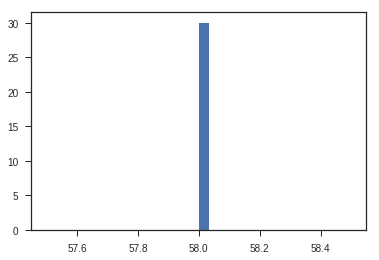

In [78]:
plot_scm_distribution(stim_scm_dict['I_40k'], 0, 1)

In [33]:
stim_dict['I_40k']

[[1, 47, 293, 0],
 [1, 54, 215, 0],
 [2, 61, 174, 1],
 [2, 45, 132, 2],
 [2, 39, 174, 4],
 [1, 45, 160, 8],
 [1, 37, 149, 1],
 [2, 72, 175, 0],
 [2, 56, 184, 1],
 [2, 76, 138, 1],
 [2, 45, 126, 0],
 [1, 52, 170, 3],
 [2, 43, 209, 7, 0, 0, 0, 0],
 [1, 48, 161, 1],
 [2, 44, 128, 0],
 [1, 34, 166, 4, 0, 0, 0, 0, 0, 0],
 [1, 37, 219, 4, 0],
 [1, 45, 158, 4],
 [1, 32, 190, 0],
 [1, 47, 198, 0]]

In [39]:
stim_betticurve_dict['I_40k'][-1][-1]

array([  1.08800000e+03,   1.00000000e+00,   4.70000000e+01,
         1.98000000e+02,   0.00000000e+00])

In [63]:
# average over all trials
import tqdm
thresh = 13.0
nsamples = 100
stim_dict = {}
stim_shuffled_dict = {}
stim_scm_dict = {}
stim_betticurve_dict = {}
stim_shuffled_betticurve_dict = {}
with h5.File(binned_data_file, 'r') as bdf:
    stims = bdf.keys()
    for stim in tqdm.tqdm(stims):
        print(stim)
        trial=0
        stim_poptens = extract_population_tensor(binned_data_file, stim)
        stim_poptens_shuffled = extract_population_tensor(binned_data_file, stim, shuffle=True)
        ntrials = num_trials(stim_poptens)
        stim_dat = []
        stim_shuffled_dat= []
        stim_scm_dat= []
        stim_betticurve_dat= []
        stim_shuffled_betticurve_dat= []
        stim_trialavg_poptens = np.mean(stim_poptens, axis=2)[:, :, np.newaxis]
        stim_trialavg_poptens_shuffled = np.mean(stim_poptens_shuffled, axis=2)[:, :, np.newaxis]
            
        #stim_bettis = compute_trial_final_bettis(stim_poptens, thresh, trial)
            
        #stim_shuffled_bettis = compute_trial_final_bettis(stim_poptens_shuffled, thresh, trial)
            
        scm_bettis = calc_scm_betti_distribution(stim_trialavg_poptens, thresh, trial, nsamples)
        
        stim_betticurves = compute_betti_curves(stim_trialavg_poptens, thresh, trial)
        stim_shuffled_betticurves = compute_betti_curves(stim_trialavg_poptens_shuffled, thresh, trial)

        stim_scm_dict[stim] = scm_bettis
        stim_betticurve_dict[stim] = stim_betticurves
        stim_shuffled_betticurve_dict[stim] = stim_shuffled_betticurves

  0%|          | 0/8 [00:00<?, ?it/s]

I_40k
Extracting Population Activity Tensor...
Stim: I_40k, Clusters:None
Extracting Population Activity Tensor...
Stim: I_40k, Clusters:None



0it [00:00, ?it/s]
1it [06:50, 410.97s/it]
2it [06:51, 287.79s/it]
3it [06:51, 201.58s/it]
4it [06:52, 141.22s/it]
5it [06:52, 98.97s/it] 
6it [06:52, 69.42s/it]
7it [06:53, 48.71s/it]
8it [06:53, 34.21s/it]
9it [06:54, 24.07s/it]
10it [06:54, 16.97s/it]
11it [06:54, 12.00s/it]
12it [06:55,  8.52s/it]
13it [06:55,  6.08s/it]
14it [06:56,  4.38s/it]
15it [06:56,  3.18s/it]
16it [06:56,  2.35s/it]
17it [06:57,  1.78s/it]
18it [06:57,  1.37s/it]
19it [06:58,  1.10s/it]
20it [06:58,  1.13it/s]
21it [06:59,  1.34it/s]
22it [06:59,  1.56it/s]
23it [06:59,  1.78it/s]
24it [07:00,  1.91it/s]
25it [07:00,  2.02it/s]
26it [07:01,  2.19it/s]
27it [07:01,  2.27it/s]
28it [07:01,  2.24it/s]
29it [07:02,  2.35it/s]
30it [07:02,  2.43it/s]
31it [07:03,  2.38it/s]
32it [07:03,  2.42it/s]
33it [07:03,  2.48it/s]
34it [07:04,  2.58it/s]
35it [07:04,  2.57it/s]
36it [07:05,  2.45it/s]
37it [07:05,  2.42it/s]
38it [07:05,  2.42it/s]
39it [07:06,  2.40it/s]
40it [07:06,  2.44it/s]
41it [07:07,  2.44it/s]


J_40k
Extracting Population Activity Tensor...
Stim: J_40k, Clusters:None
Extracting Population Activity Tensor...
Stim: J_40k, Clusters:None



0it [00:00, ?it/s]
1it [04:47, 287.67s/it]
3it [04:47, 201.39s/it]
5it [04:48, 141.00s/it]
6it [04:48, 98.73s/it] 
8it [04:48, 69.14s/it]
10it [04:48, 48.42s/it]
12it [04:48, 33.92s/it]
13it [04:48, 23.78s/it]
15it [04:48, 16.67s/it]
17it [04:49, 11.70s/it]
19it [04:49,  8.21s/it]
21it [04:49,  5.78s/it]
23it [04:49,  4.07s/it]
25it [04:49,  2.88s/it]
27it [04:50,  2.04s/it]
29it [04:50,  1.46s/it]
31it [04:50,  1.05s/it]
33it [04:50,  1.31it/s]
35it [04:50,  1.77it/s]
37it [04:51,  2.36it/s]
39it [04:51,  3.07it/s]
41it [04:51,  3.86it/s]
43it [04:51,  4.80it/s]
45it [04:51,  5.75it/s]
47it [04:51,  6.69it/s]
49it [04:52,  7.46it/s]
51it [04:52,  8.23it/s]
53it [04:52,  8.88it/s]
55it [04:52,  9.16it/s]
57it [04:52,  9.60it/s]
59it [04:53,  9.66it/s]
61it [04:53,  9.87it/s]
63it [04:53, 10.04it/s]
65it [04:53, 10.25it/s]
67it [04:53, 10.59it/s]
69it [04:54, 10.69it/s]
71it [04:54, 10.87it/s]
73it [04:54, 10.97it/s]
75it [04:54, 10.54it/s]
77it [04:54,  9.79it/s]
78it [04:54,  9.83it/

K_40k
Extracting Population Activity Tensor...
Stim: K_40k, Clusters:None
Extracting Population Activity Tensor...
Stim: K_40k, Clusters:None



0it [00:00, ?it/s]
1it [04:56, 296.53s/it]
2it [04:56, 207.62s/it]
3it [04:56, 145.39s/it]
4it [04:57, 101.83s/it]
5it [04:57, 71.34s/it] 
6it [04:57, 49.99s/it]
7it [04:57, 35.04s/it]
8it [04:57, 24.58s/it]
9it [04:57, 17.26s/it]
10it [04:58, 12.13s/it]
11it [04:58,  8.55s/it]
12it [04:58,  6.03s/it]
13it [04:58,  4.29s/it]
14it [04:58,  3.06s/it]
15it [04:59,  2.19s/it]
16it [04:59,  1.59s/it]
17it [04:59,  1.17s/it]
18it [04:59,  1.15it/s]
19it [04:59,  1.50it/s]
20it [04:59,  1.94it/s]
21it [05:00,  2.44it/s]
22it [05:00,  2.95it/s]
23it [05:00,  3.45it/s]
24it [05:00,  3.92it/s]
25it [05:00,  4.27it/s]
26it [05:01,  4.43it/s]
27it [05:01,  4.81it/s]
28it [05:01,  4.87it/s]
29it [05:01,  5.16it/s]
30it [05:01,  5.30it/s]
31it [05:01,  5.35it/s]
32it [05:02,  5.51it/s]
33it [05:02,  5.58it/s]
34it [05:02,  5.66it/s]
35it [05:02,  5.80it/s]
36it [05:02,  5.66it/s]
37it [05:02,  5.51it/s]
38it [05:03,  5.55it/s]
39it [05:03,  5.67it/s]
40it [05:03,  5.63it/s]
41it [05:03,  5.73it/s]


L_40k
Extracting Population Activity Tensor...
Stim: L_40k, Clusters:None
Extracting Population Activity Tensor...
Stim: L_40k, Clusters:None



0it [00:00, ?it/s]
1it [02:17, 137.26s/it]
2it [02:17, 96.18s/it] 
3it [02:17, 67.42s/it]
4it [02:18, 47.28s/it]
5it [02:18, 33.19s/it]
6it [02:18, 23.32s/it]
7it [02:19, 16.42s/it]
8it [02:19, 11.58s/it]
9it [02:19,  8.19s/it]
10it [02:20,  5.83s/it]
11it [02:20,  4.17s/it]
12it [02:20,  3.01s/it]
13it [02:20,  2.20s/it]
14it [02:21,  1.64s/it]
15it [02:21,  1.25s/it]
16it [02:21,  1.03it/s]
17it [02:22,  1.31it/s]
18it [02:22,  1.61it/s]
19it [02:22,  1.90it/s]
20it [02:23,  2.21it/s]
21it [02:23,  2.40it/s]
22it [02:23,  2.63it/s]
23it [02:23,  2.81it/s]
24it [02:24,  2.95it/s]
25it [02:24,  3.08it/s]
26it [02:24,  3.08it/s]
27it [02:25,  3.18it/s]
28it [02:25,  3.20it/s]
29it [02:25,  3.29it/s]
30it [02:26,  3.30it/s]
31it [02:26,  3.36it/s]
32it [02:26,  3.34it/s]
33it [02:26,  3.39it/s]
34it [02:27,  3.40it/s]
35it [02:27,  3.24it/s]
36it [02:27,  3.32it/s]
37it [02:28,  3.39it/s]
38it [02:28,  3.26it/s]
39it [02:28,  3.31it/s]
40it [02:29,  3.37it/s]
41it [02:29,  3.36it/s]
42i

M_40k
Extracting Population Activity Tensor...
Stim: M_40k, Clusters:None
Extracting Population Activity Tensor...
Stim: M_40k, Clusters:None



1it [06:04, 364.61s/it]
2it [06:04, 255.27s/it]
3it [06:04, 178.74s/it]
4it [06:05, 125.16s/it]
5it [06:05, 87.65s/it] 
6it [06:05, 61.40s/it]
7it [06:05, 43.02s/it]
8it [06:05, 30.16s/it]
9it [06:05, 21.15s/it]
10it [06:05, 14.85s/it]
11it [06:06, 10.44s/it]
12it [06:06,  7.36s/it]
13it [06:06,  5.19s/it]
14it [06:06,  3.68s/it]
15it [06:06,  2.62s/it]
16it [06:06,  1.87s/it]
17it [06:06,  1.36s/it]
18it [06:07,  1.01it/s]
19it [06:07,  1.34it/s]
20it [06:07,  1.77it/s]
21it [06:07,  2.27it/s]
22it [06:07,  2.80it/s]
23it [06:07,  3.41it/s]
24it [06:08,  3.90it/s]
25it [06:08,  4.58it/s]
26it [06:08,  4.77it/s]
27it [06:08,  5.20it/s]
28it [06:08,  5.53it/s]
29it [06:08,  5.76it/s]
30it [06:08,  6.09it/s]
31it [06:09,  6.24it/s]
32it [06:09,  6.28it/s]
33it [06:09,  6.12it/s]
34it [06:09,  6.17it/s]
35it [06:09,  6.56it/s]
36it [06:09,  6.58it/s]
37it [06:10,  6.44it/s]
38it [06:10,  6.52it/s]
39it [06:10,  6.64it/s]
40it [06:10,  6.77it/s]
41it [06:10,  6.99it/s]
42it [06:10,  7.21i

N_40k
Extracting Population Activity Tensor...
Stim: N_40k, Clusters:None
Extracting Population Activity Tensor...
Stim: N_40k, Clusters:None



1it [06:28, 388.04s/it]
2it [06:28, 271.72s/it]
3it [06:28, 190.30s/it]
4it [06:28, 133.30s/it]
5it [06:29, 93.40s/it] 
6it [06:29, 65.47s/it]
7it [06:29, 45.93s/it]
8it [06:30, 32.24s/it]
9it [06:30, 22.67s/it]
10it [06:30, 15.96s/it]
11it [06:31, 11.27s/it]
12it [06:31,  7.97s/it]
13it [06:31,  5.68s/it]
14it [06:32,  4.06s/it]
15it [06:32,  2.95s/it]
16it [06:32,  2.17s/it]
17it [06:33,  1.63s/it]
18it [06:33,  1.23s/it]
19it [06:33,  1.04it/s]
20it [06:34,  1.28it/s]
21it [06:34,  1.51it/s]
22it [06:34,  1.80it/s]
23it [06:35,  2.08it/s]
24it [06:35,  2.32it/s]
25it [06:35,  2.45it/s]
26it [06:36,  2.67it/s]
27it [06:36,  2.82it/s]
28it [06:36,  2.85it/s]
29it [06:37,  2.79it/s]
30it [06:37,  2.91it/s]
31it [06:37,  3.03it/s]
32it [06:38,  3.09it/s]
33it [06:38,  3.16it/s]
34it [06:38,  3.21it/s]
35it [06:38,  3.14it/s]
36it [06:39,  3.17it/s]
37it [06:39,  3.19it/s]
38it [06:39,  3.16it/s]
39it [06:40,  3.18it/s]
40it [06:40,  3.10it/s]
41it [06:40,  3.05it/s]
42it [06:41,  3.08i

O_40k
Extracting Population Activity Tensor...
Stim: O_40k, Clusters:None
Extracting Population Activity Tensor...
Stim: O_40k, Clusters:None



1it [02:58, 178.92s/it]
6it [02:59, 125.25s/it]
11it [02:59, 87.68s/it]
16it [02:59, 61.39s/it]
21it [02:59, 42.98s/it]
26it [02:59, 30.09s/it]
31it [02:59, 21.07s/it]
36it [02:59, 14.76s/it]
41it [02:59, 10.34s/it]
46it [02:59,  7.24s/it]
51it [03:00,  5.08s/it]
56it [03:00,  3.56s/it]
61it [03:00,  2.50s/it]
66it [03:00,  1.76s/it]
71it [03:00,  1.24s/it]
76it [03:00,  1.15it/s]
81it [03:00,  1.62it/s]
86it [03:00,  2.28it/s]
91it [03:00,  3.19it/s]
96it [03:01,  4.41it/s]
 88%|████████▊ | 7/8 [36:53<05:06, 306.68s/it]
0it [00:00, ?it/s]

P_40k
Extracting Population Activity Tensor...
Stim: P_40k, Clusters:None
Extracting Population Activity Tensor...
Stim: P_40k, Clusters:None



1it [03:11, 191.77s/it]
4it [03:11, 134.25s/it]
7it [03:12, 93.99s/it] 
10it [03:12, 65.80s/it]
13it [03:12, 46.07s/it]
16it [03:12, 32.26s/it]
19it [03:12, 22.60s/it]
22it [03:12, 15.83s/it]
25it [03:12, 11.09s/it]
28it [03:12,  7.78s/it]
31it [03:12,  5.45s/it]
34it [03:13,  3.83s/it]
37it [03:13,  2.69s/it]
40it [03:13,  1.89s/it]
43it [03:13,  1.34s/it]
46it [03:13,  1.06it/s]
49it [03:13,  1.49it/s]
52it [03:13,  2.07it/s]
55it [03:13,  2.87it/s]
58it [03:13,  3.93it/s]
61it [03:13,  5.30it/s]
64it [03:14,  6.99it/s]
67it [03:14,  9.02it/s]
70it [03:14, 11.21it/s]
73it [03:14, 13.73it/s]
76it [03:14, 16.30it/s]
79it [03:14, 18.86it/s]
83it [03:14, 21.21it/s]
86it [03:14, 23.18it/s]
89it [03:14, 24.75it/s]
92it [03:15, 26.09it/s]
95it [03:15, 26.99it/s]
98it [03:15, 27.49it/s]
100%|██████████| 8/8 [40:09<00:00, 273.39s/it]


KeysView(<Closed HDF5 file>)

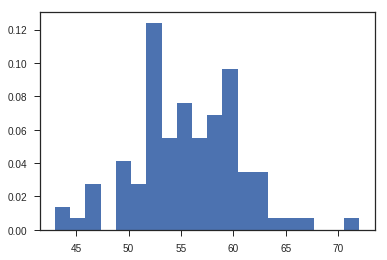

In [95]:
plot_scm_distribution([stim_scm_dict['L_40k']], 0, 1)
stims

In [93]:
stim_betticurve_dict['L_40k'][-1]

array([  1.14700000e+03,   2.00000000e+00,   7.30000000e+01,
         1.00000000e+01,   1.00000000e+00,   2.00000000e+00])

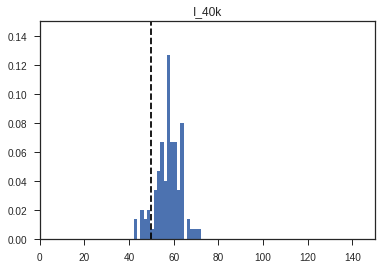

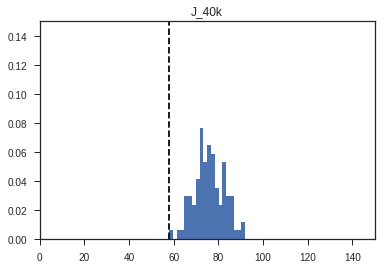

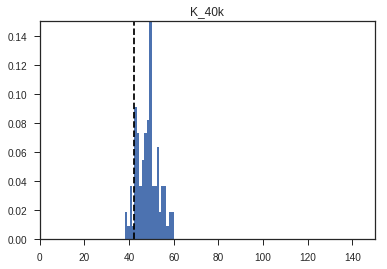

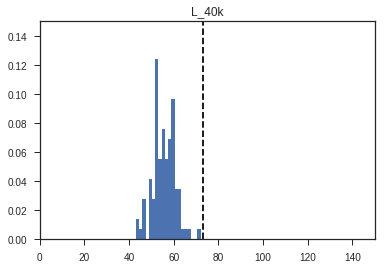

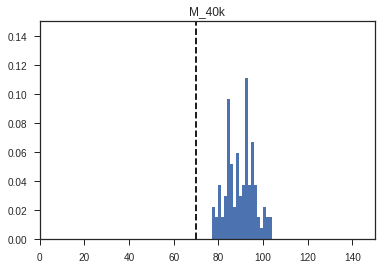

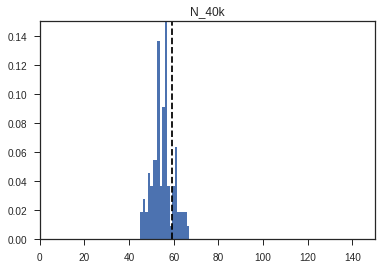

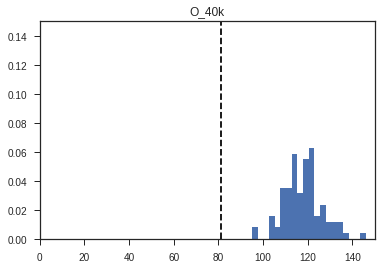

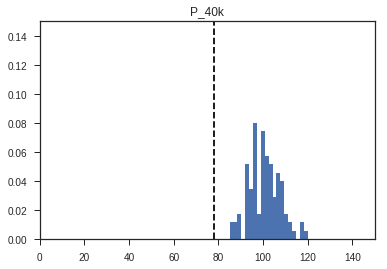

In [100]:
for stim in stim_betticurve_dict.keys():
    final_bettis = stim_betticurve_dict[stim][-1]
    plt.figure()
    plot_scm_distribution([stim_scm_dict[stim]], 0, 1)
    b = final_bettis[2]
    plt.plot([b, b], [0, 0.15], 'k--')
    plt.title(stim)
    plt.xlim([0, 150])
    plt.ylim([0, 0.15])